## Loading the Data:

In [35]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import re
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn import metrics
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [38]:
data = pd.read_excel('/content/drive/MyDrive/ass.1.xlsx')
data.head(10)
data.shape
data.head(10)

,article_id,title,text,published_date,unique_tokens_rate,num_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel,min_avg_key,max_avg_key,avg_avg_key,href_avg_shares,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,title_subjectivity,title_sentiment_polarity,shares
0,7014291,It's Time for a YouTube Competitor,It was reported last week that Yahoo is gettin...,2014-03-31,0.640816,5,3,1,4.579592,5,Business,1459.500,4817.692,3370.415,1833.333,0.403762,0.038762,0.036735,0.024490,0.250000,0.250000,1600
1,7014327,The Ultimate Roundup of 2014's Biggest April F...,April Fools' marks the day when pranking goes ...,2014-04-01,0.549618,4,1,0,4.636704,7,Tech,0.000,3581.094,2556.367,8500.000,0.410707,0.180934,0.044944,0.003745,0.000000,0.000000,1500
2,7014304,A Selfie and One Garish Jacket: How the Red So...,The 2013 World Series champion Boston Red Sox ...,2014-04-01,0.577236,8,1,0,4.627451,7,Tech,2270.889,3852.800,3018.167,2076.333,0.397545,0.044864,0.035294,0.019608,0.000000,0.000000,1400
3,7031995,African Telecom Proposes More Diverse Emoticons,Less than a week after Apple pledged to make i...,2014-04-01,0.525896,4,1,0,5.083665,9,Tech,0.000,3581.094,1871.403,2200.000,0.491578,0.157620,0.047809,0.011952,0.000000,0.000000,1300
4,6541359,"Google to Launch Improved Android Camera App, ...",Android users may soon see a series of new fea...,2014-04-01,0.588889,6,9,0,4.336022,7,00000,3581.094,8453.451,5155.323,805.000,0.628535,0.078497,0.053763,0.034946,0.000000,0.000000,3000
5,7033985,Apple to Begin iPhone 6 Screen Production in M...,Whispers surrounding a possible iPhone 6 relea...,2014-04-01,0.494269,8,1,0,4.360679,4,Business,3343.790,4817.692,3974.216,31625.000,0.567866,0.098980,0.038190,0.024045,0.666667,-0.333330,1600
6,7014312,"Apple Updates iWork for OS X, iOS and iCloud","Apple updated its iWork suite Tuesday, adding ...",2014-04-01,0.639706,4,1,0,4.594444,7,Lifestyle,2499.333,5549.418,3667.217,4800.000,0.347222,0.186111,0.033333,0.005556,0.000000,0.000000,1300
7,3299703,Spare Your Facebook Friends From These 9 April...,Everybody's a comedian -- at least they think ...,2014-04-01,0.508511,26,8,0,4.713427,7,Tech,3030.861,4622.544,3761.262,3700.000,0.484539,0.134520,0.050100,0.026052,0.400000,-0.150000,2000
8,7014271,Why Tech Takes April Fools' Day So Seriously,Tech journalists hate April Fools' Day. Not be...,2014-04-01,0.481013,9,3,1,4.374613,8,Lifestyle,0.000,6813.466,3745.055,11800.000,0.533060,0.186324,0.046440,0.021672,0.066667,0.033333,2100
9,7008095,Atlanta Is World's Busiest Airport With 94 Mil...,Atlanta's Hartsfield-Jackson airport remained ...,2014-04-01,0.422028,11,1,0,4.272043,5,Business,3343.790,5585.617,4111.006,2600.000,0.502861,0.121931,0.043011,0.018280,0.357143,0.000000,1100


In [39]:
df = data.copy()

In [40]:
df['article_length'] = df['text'].apply(len)
df['published_day'] = pd.to_datetime(df['published_date']).dt.day_name()

In [41]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
numerical_cols = ['unique_tokens_rate', 'num_hrefs', 'num_imgs', 'num_videos', 'average_token_length', 'article_length']
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [42]:
# Dropping 'title' and 'text' columns
df = df.drop(['title', 'text', 'data_channel'], axis=1)
# Splitting the dataset into features and target variable
X = df.drop('shares', axis=1)
y = df['shares']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
x_train['published_date'] = pd.to_datetime(x_train['published_date'])
x_test['published_date'] = pd.to_datetime(x_test['published_date'])
x_train['day_of_week'] = x_train['published_date'].dt.dayofweek
x_train['quarter'] = x_train['published_date'].dt.quarter
x_test['day_of_week'] = x_test['published_date'].dt.dayofweek
x_test['quarter'] = x_test['published_date'].dt.quarter

In [44]:
non_numeric_columns = x_train.select_dtypes(exclude=['number']).columns
print("Non-numeric columns:", non_numeric_columns)

Non-numeric columns: Index(['published_date', 'published_day'], dtype='object')


In [45]:
x_train = x_train.drop(non_numeric_columns, axis=1)
x_test = x_test.drop(non_numeric_columns, axis=1)

In [46]:
import numpy as np
print("Infinity values in x_train:", np.any(np.isinf(x_train)))
print("Large values in x_train:", np.any(np.abs(x_train) > 1e15))
print("Infinity values in y_train:", np.any(np.isinf(y_train)))
print("Large values in y_train:", np.any(np.abs(y_train) > 1e15))

Infinity values in x_train: False
Large values in x_train: False
Infinity values in y_train: False
Large values in y_train: False


In [47]:
# Replace large values with a reasonable value
x_train[np.abs(x_train) > 1e15] = np.nan
x_train = np.nan_to_num(x_train)

In [49]:
x_test[np.abs(x_test) > 1e15] = np.nan
x_test = np.nan_to_num(x_test)

## Models:

### Linear Regression:

In [51]:
# Model training
from sklearn.linear_model import LinearRegression
linear_reg = LinearRegression()
linear_reg.fit(x_train,y_train)
print("Training R2 score: "+ str(linear_reg.score(x_train,y_train)))

Training R2 score: 0.0714657238785894


In [52]:
# Predicting on the test and evaluating the accuracy
preds_lr = linear_reg.predict(x_test)
print("Test R2 score: "+ str(metrics.r2_score(y_test,preds_lr)))
print("Test MAE: "+ str(metrics.mean_absolute_error(y_test,preds_lr)))
print("Test RMSE: "+ str(np.sqrt(metrics.mean_squared_error(y_test,preds_lr))))

Test R2 score: -0.003859443694981479
Test MAE: 6608.183365531114
Test RMSE: 46736.54506987125


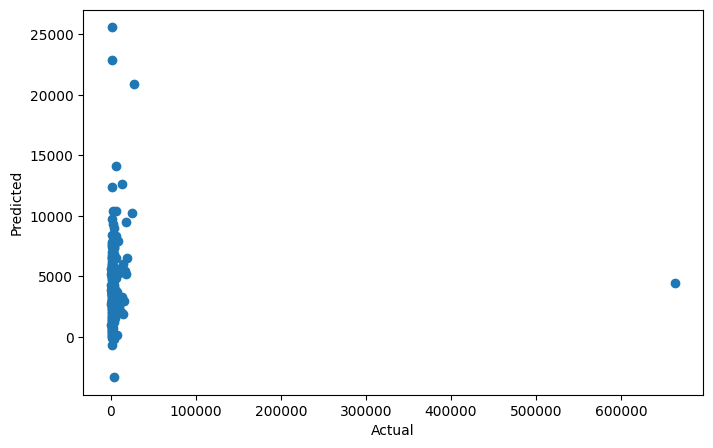

In [53]:
# Plotting the predicted and actual data
plt.figure(figsize=(8,5))
plt.scatter(y_test,preds_lr)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

### Ridge Regression: (L2 Regularization)

In [54]:
# Model training
from sklearn.linear_model import Ridge
ridge = Ridge()
ridge.fit(x_train,y_train)
print("Training R2 score: "+ str(ridge.score(x_train,y_train)))

Training R2 score: 0.06717067875951688


In [55]:
# Predicting on the test and evaluating the accuracy
preds_rid = ridge.predict(x_test)

print("Test R2 score: "+ str(metrics.r2_score(y_test,preds_rid)))
print("Test MAE: "+ str(metrics.mean_absolute_error(y_test,preds_rid)))
print("Test RMSE: "+ str(np.sqrt(metrics.mean_squared_error(y_test,preds_rid))))

Test R2 score: -0.002592020141783058
Test MAE: 6537.2508509288455
Test RMSE: 46707.032120125325


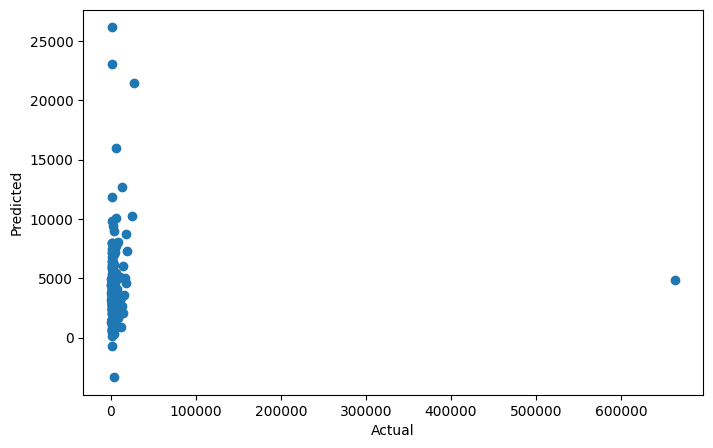

In [56]:
# Plotting the predicted and actual data
plt.figure(figsize=(8,5))
plt.scatter(y_test,preds_rid)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

### Lasso Regression: (L1 Regularization)

In [57]:
# Model training
from sklearn.linear_model import Lasso
las = Lasso()
las.fit(x_train,y_train)
print("Training R2 score: "+ str(las.score(x_train,y_train)))

Training R2 score: 0.0709605425454537


In [58]:
# Predicting on the test and evaluating the accuracy
preds_las = las.predict(x_test).reshape(-1,1)
print("Test R2 score: "+ str(metrics.r2_score(y_test,preds_las)))
print("Test MAE: "+ str(metrics.mean_absolute_error(y_test,preds_las)))
print("Test RMSE: "+ str(np.sqrt(metrics.mean_squared_error(y_test,preds_las))))

Test R2 score: -0.0031790760124332795
Test MAE: 6577.041932625829
Test RMSE: 46720.704493443576


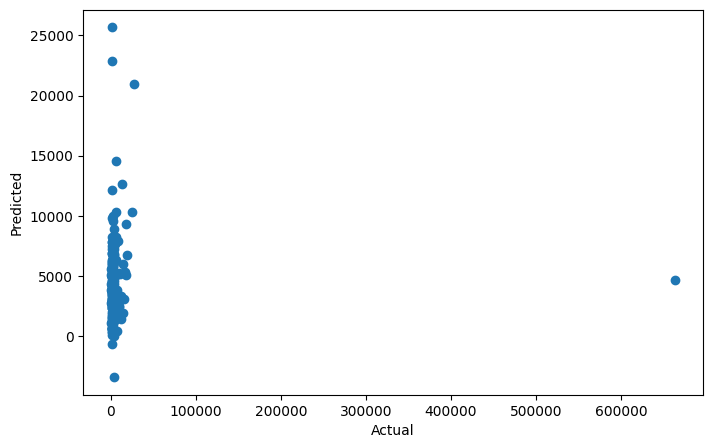

In [59]:
# Plotting the predicted and actual data
plt.figure(figsize=(8,5))
plt.scatter(y_test,preds_las)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

## Ensemble:

In [60]:
# Model training
from sklearn.ensemble import VotingRegressor
estimators = [('lr',linear_reg),('rid',ridge),('lasso',las)]
voting_ensemble = VotingRegressor(estimators,)
voting_ensemble.fit(x_train,y_train)
print("Training R2 score: "+ str(voting_ensemble.score(x_train,y_train)))

Training R2 score: 0.07063198549866101


In [61]:
# Predicting on the test and evaluating the accuracy
preds_vote = voting_ensemble.predict(x_test)
print("Test R2 score: "+ str(metrics.r2_score(y_test,preds_vote)))
print("Test MAE: "+ str(metrics.mean_absolute_error(y_test,preds_vote)))
print("Test RMSE: "+ str(np.sqrt(metrics.mean_squared_error(y_test,preds_vote))))

Test R2 score: -0.0031837522618851644
Test MAE: 6561.314816873202
Test RMSE: 46720.81338597304


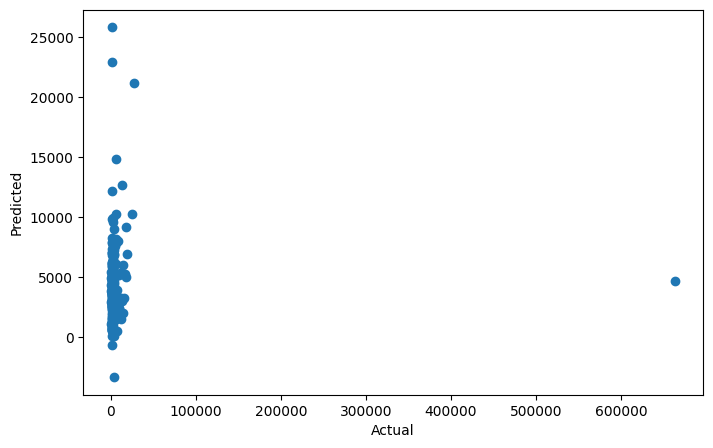

In [62]:
# Plotting the predicted and actual data
plt.figure(figsize=(8,5))
plt.scatter(y_test,preds_vote)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()